# Exploratory Data Analysis - Air Pollution Example


### Goals

* Assess the quantity, quality of your data.
* Is there structure in the data that needs to be modeled?
* Which features are relevant for the mode?

In [1]:
# import all libraries used in this notebook
require(sf)
require(geojsonio)
require(ggplot2)
require(dplyr)
suppressMessages(library(sf))
suppressMessages(library(geojsonio))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
options(width = 100)

Loading required package: sf

Linking to GEOS 3.10.2, GDAL 3.4.2, PROJ 8.2.1; sf_use_s2() is TRUE

Loading required package: geojsonio

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: ‘geojsonio’


The following object is masked from ‘package:base’:

    pretty


Loading required package: ggplot2

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Dataset: Exposure to particulate matter less than 2.5 microns in diameter


Our goal is to build a model of ground-level air pollution, using measurements from ground monitors together
with satellite imaging data.
The dataset is taken from github repository: https://github.com/jgabry/bayes-vis-paper
which contain all materials for the paper **_Visualization in Bayesian workflow_**:    

Gabry, J. , Simpson, D. , Vehtari, A. , Betancourt, M. and Gelman, A. (2019),     
Visualization in Bayesian workflow. _J. R. Stat. Soc. A_, 182: 389-402. doi:10.1111/rssa.12378

* Published JRSS version: https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssa.12378
* arXiv preprint: https://arxiv.org/pdf/1709.01449.pdf (includes Supplementary Materials in appendix)

A local version of the raw data for this paper is in the `data` directory, named `GM_spdf.RData`.
This [RDATA file](https://github.com/jgabry/bayes-vis-paper/blob/master/bayes-vis.RData) contains a single R [SpatialPointsDataFrame](https://rdrr.io/cran/sp/man/SpatialPoints.html).

We have converted this to a [GeoJson](https://geojson.org) file, `data/air_spdf.geojson` which contains just the information needed for this analysis.

The dataset for this paper consists of measurements of ambient ${PM}_{2.5}$ collected from ground monitors
together with the corresponding measurement from high-resolution satellite data for that geo-location.
The data was collected accros 100 countries, which have been grouped into 7 categories by the World Health Organization (WHO).
Each observation consists of the following:

- 3-letter ISO country code
- location name
- a pair of latitude, longitude coordinates (in WGS84)
- ${PM}_{2.5}$ measurements from ground monitors, and log(ground PM)
- ${PM}_{2.5}$ measurements from via high-resolution satellite data, and log(satelite PM)
- World Health Organization (WHO) super-region name
- 6-component hierarchical clustering of ground monitor measurements
- 6-component hierarchical clustering of log ground monitor measurements

In [2]:
pm_gdf = geojson_read("data/air_spdf.geojson", parse=TRUE, what="sp", stringsAsFactors=TRUE)
sites <- st_as_sf(pm_gdf)
sites$super_region_name <- factor(sites$super_region_name)
str(sites)

Classes ‘sf’ and 'data.frame':	6003 obs. of  12 variables:
 $ iso3              : Factor w/ 107 levels "AFG","ALB","AND",..: 1 1 2 3 4 4 4 4 4 4 ...
 $ latitude          : num  34.5 36.7 41.3 42.5 24.4 ...
 $ longitude         : num  69.19 67.12 19.82 1.54 54.5 ...
 $ pm25              : num  86 68 16 11 53 63 57 61 60 46 ...
 $ sat_2014          : num  25.93 33.34 19.47 6.61 45.65 ...
 $ super_region      : int  3 3 4 1 2 2 2 2 2 2 ...
 $ super_region_name : Factor w/ 7 levels "Central Europe, Eastern Europe, Central Asia",..: 5 5 1 2 4 4 4 4 4 4 ...
 $ log_pm25          : num  4.45 4.22 2.77 2.4 3.97 ...
 $ log_sat           : num  3.26 3.51 2.97 1.89 3.82 ...
 $ cluster_region    : int  1 1 2 2 3 3 3 3 3 3 ...
 $ cluster_log_region: int  1 1 2 3 4 4 4 4 4 4 ...
 $ geometry          :sfc_POINT of length 6003; first list element:  'XY' num  69.2 34.5
 - attr(*, "sf_column")= chr "geometry"
 - attr(*, "agr")= Factor w/ 3 levels "constant","aggregate",..: NA NA NA NA NA NA NA NA NA NA .

In [3]:
head(sites)

iso3 latitude longitude pm25 sat_2014 super_region super_region_name                           
1 AFG  34.53076 69.191277 86   25.93149 3            South Asia                                  
2 AFG  36.70000 67.116669 68   33.34350 3            South Asia                                  
3 ALB  41.33027 19.821772 16   19.46800 4            Central Europe, Eastern Europe, Central Asia
4 AND  42.50969  1.539139 11    6.60900 1            High income                                 
5 ARE  24.40638 54.504269 53   45.65450 2            North Africa / Middle East                  
6 ARE  24.34735 54.650124 63   45.66200 2            North Africa / Middle East                  
  log_pm25 log_sat  cluster_region cluster_log_region geometry                 
1 4.454347 3.255458 1              1                  POINT (69.19128 34.53076)
2 4.219508 3.506863 1              1                  POINT (67.11667 36.7)    
3 2.772589 2.968772 2              2                  POINT (19.82177 41.33027)
4 2.397895 1.888432 2              3                  POINT (1.539139 42.50969)
5 3.970292 3.821102 3              4                  POINT (54.50427 24.40638)
6 4.143135 3.821267 3              4                  POINT (54.65012 24.34735)

What is the range of observed measurements of ${PM}_{2.5}$ and log ${PM}_{2.5}$ from ground monitors and satellites?

In [4]:
cat("pm_25")
summary(sites$pm25)
cat("log_pm")
summary(sites$log_pm25)
cat("sat_2014")
summary(sites$sat_2014)
cat("log_sat")
summary(sites$log_sat)

pm_25

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00   11.00   17.00   27.53   37.00  288.00 

log_pm

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6931  2.3979  2.8332  2.9828  3.6109  5.6630 

sat_2014

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.300   9.051  16.983  25.528  33.102 102.832 

log_sat

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8327  2.2029  2.8322  2.8564  3.4996  4.6331 

To properly visualize the distribution of measurements around the globe we need a map which contains country boundaries.
We have downloaded a world map shapefile (in coordinate system WGS84) from
[Natural Earth](https://www.naturalearthdata.com/), which provides free public domain datasets.

We add the per-country WHO super region names and cluster regions to the world map so that we can color countries by super region and clustered region.

Reading layer `ne_110m_admin_0_countries' from data source 
  `/Users/mitzi/github/zmorris/2023_stancon_workflow/stancon_brms_notebooks/data/ne_110m_admin_0_countries' 
  using driver `ESRI Shapefile'
Simple feature collection with 177 features and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -90 xmax: 180 ymax: 83.64513
Geodetic CRS:  WGS 84


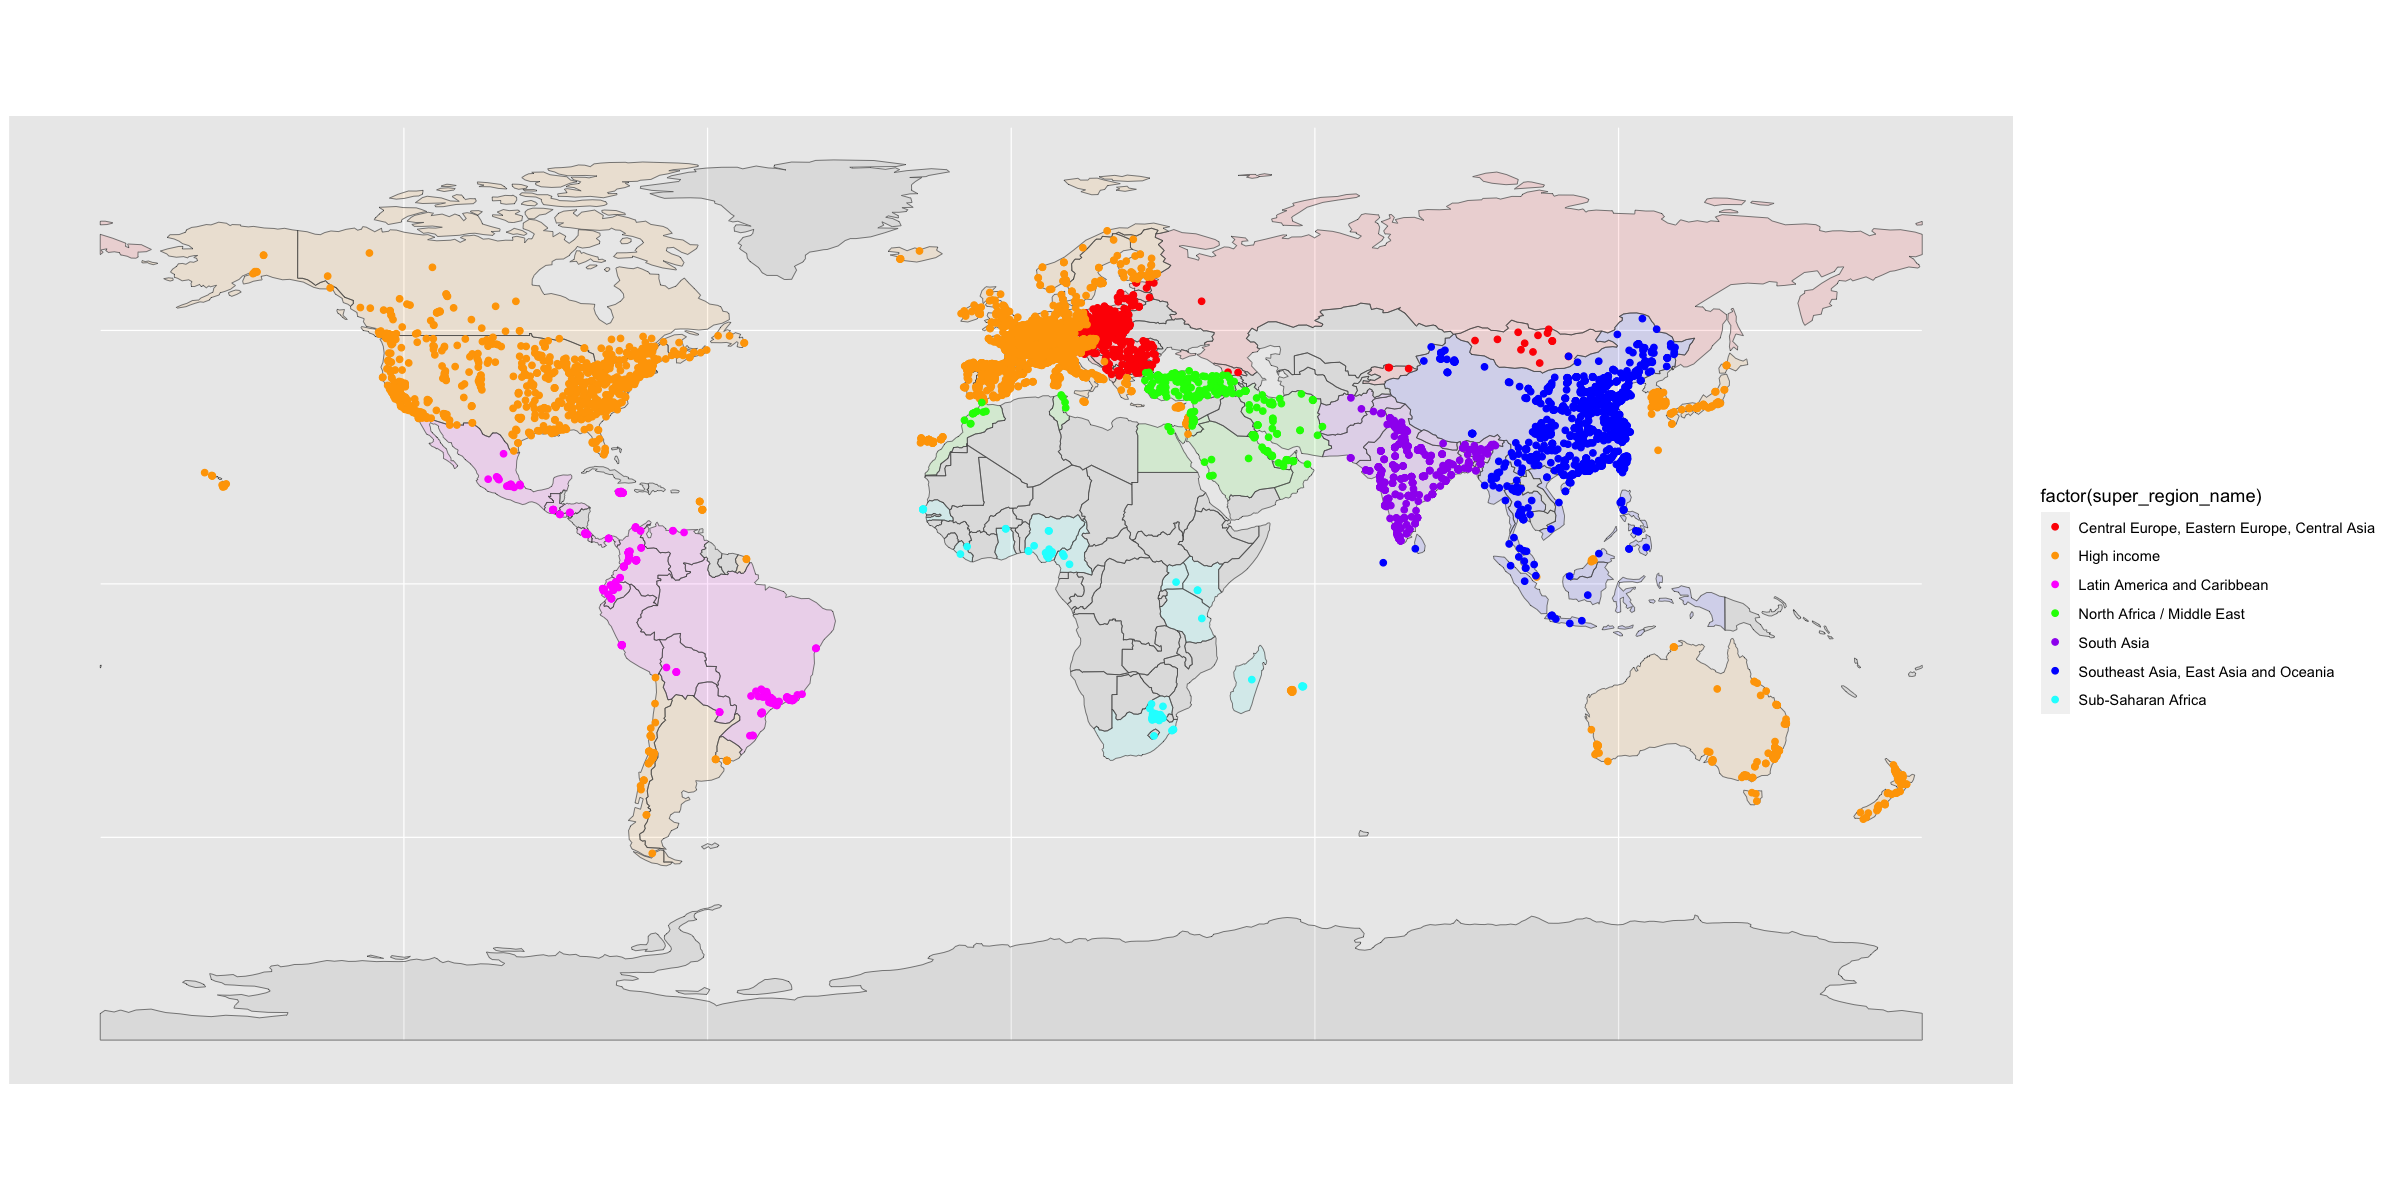

In [5]:
world_map_gdf = st_read(dsn = "data/ne_110m_admin_0_countries", layer="ne_110m_admin_0_countries")
countries <- as.data.frame(sites) %>% select(iso3, super_region_name, super_region, cluster_region, cluster_log_region) %>% distinct()
world_map_plus_gdf <- merge(world_map_gdf, countries, by.x = 'ISO_A3_EH', by.y = 'iso3', all.x = TRUE)

options(repr.plot.width=20, repr.plot.height=10)
ggplot() +  
 geom_sf(data = world_map_plus_gdf, aes(fill=factor(super_region_name)), alpha=0.1) +
 geom_sf(data = sites, aes(color=factor(super_region_name))) +
 scale_color_manual(values = c('red', 'orange', 'magenta', 'green', 'purple', 'blue', 'cyan')) +
 scale_fill_manual(values = c('red', 'orange', 'magenta', 'green', 'purple', 'blue', 'cyan', 'ivory')) +
         guides(fill='none')

Alternatively, we can color countries by region and show ground monitor points by log_pm25 readings.   Green and yellows indicate low readings, red and orange indicate high readings.

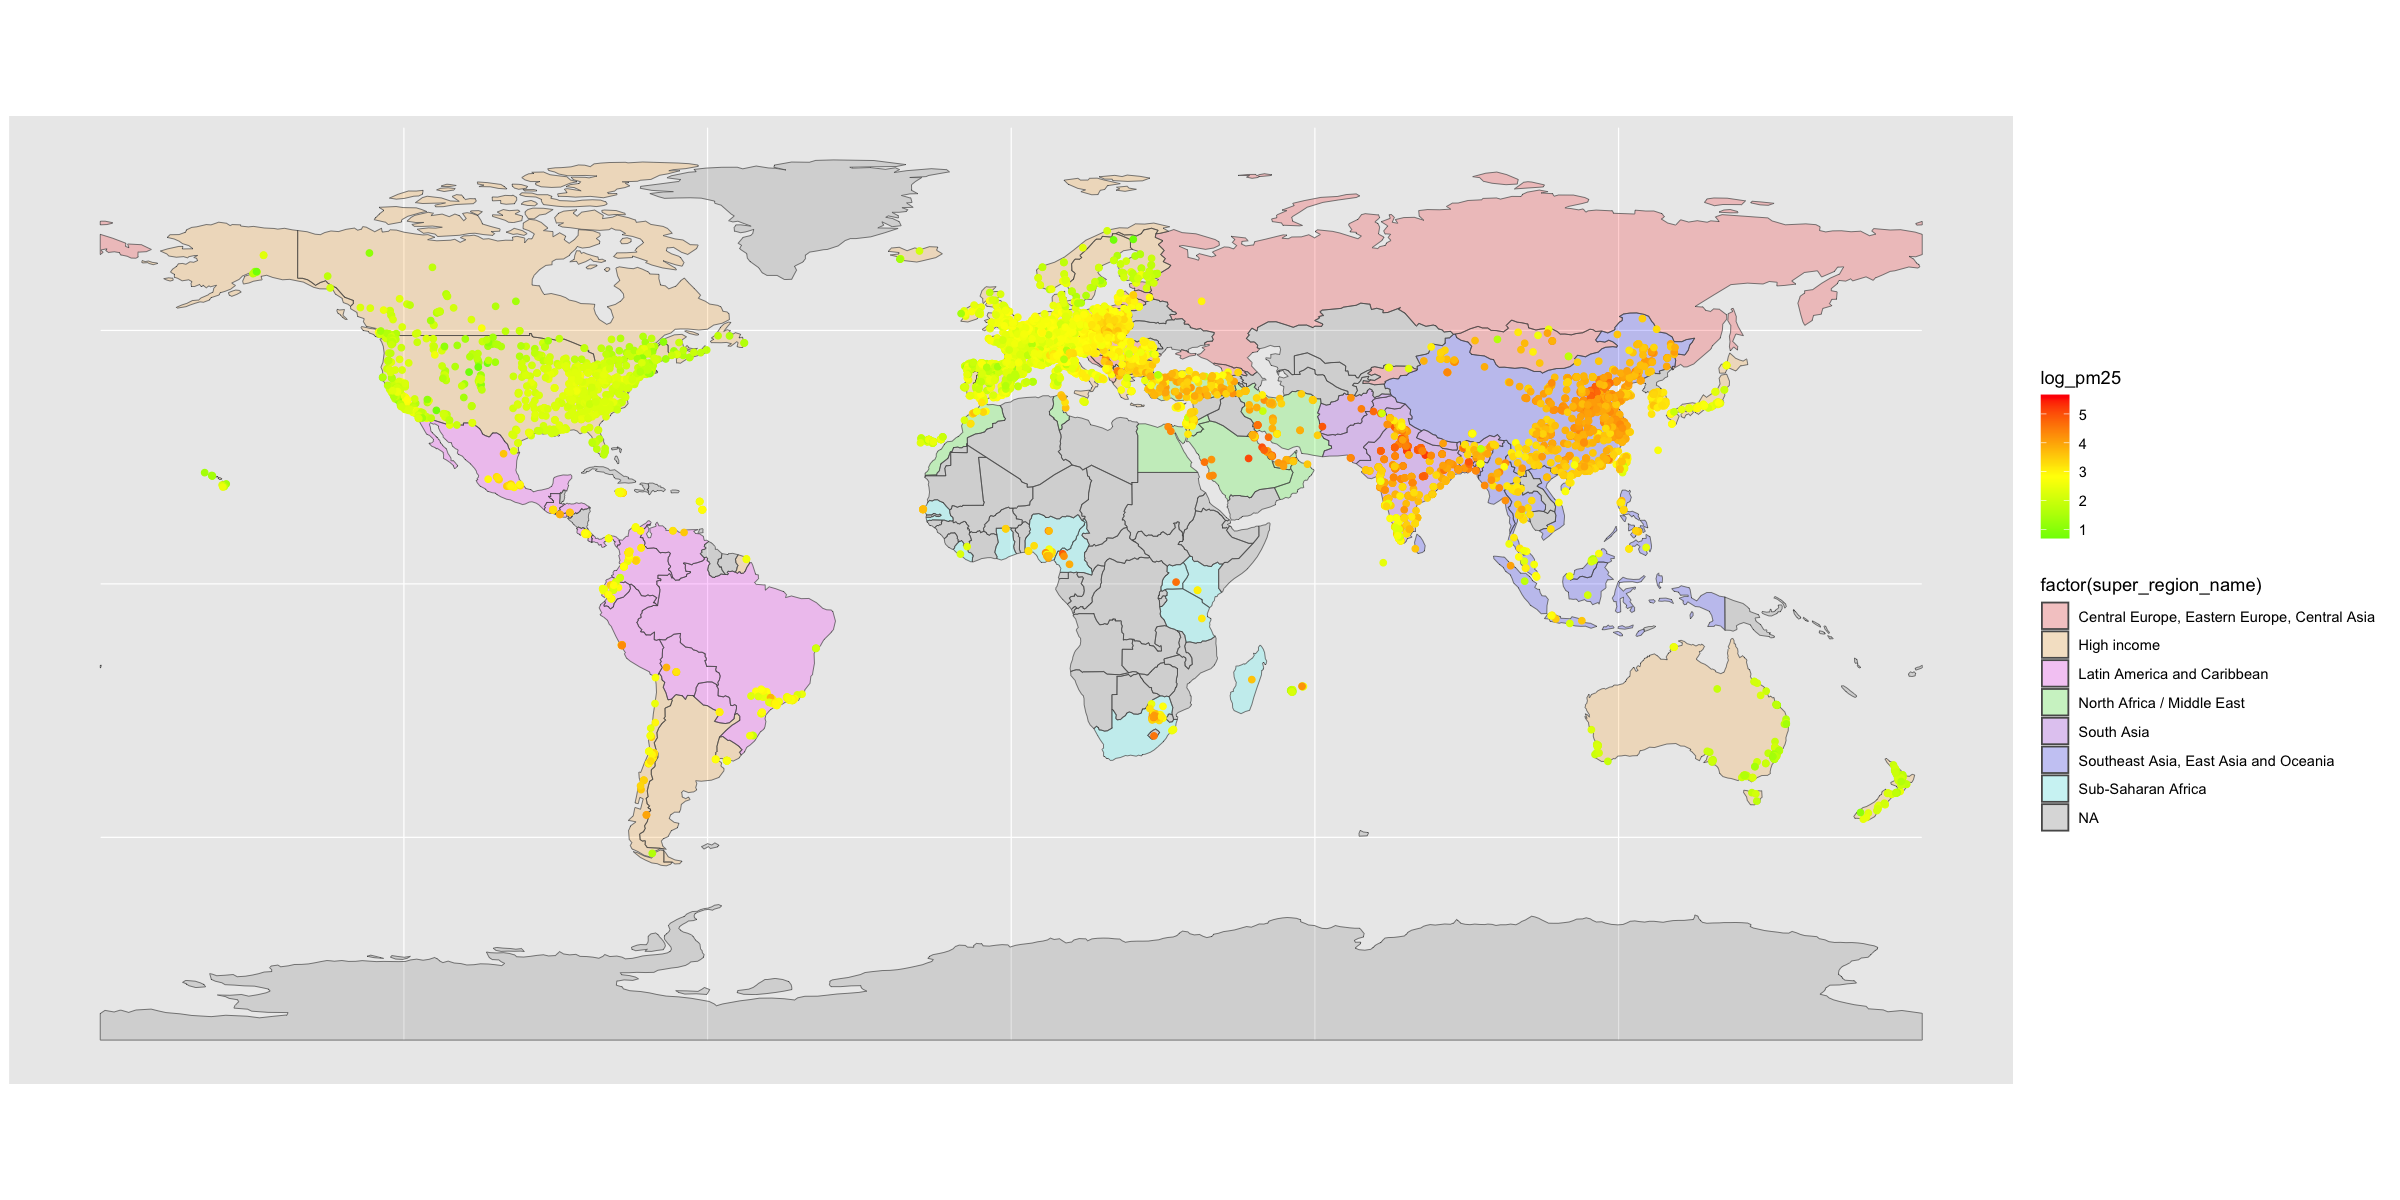

In [6]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot() +  
 geom_sf(data = world_map_plus_gdf, aes(fill=factor(super_region_name)), alpha=0.2) +
 geom_sf(data = sites, aes(color=log_pm25)) +
 scale_color_gradient2(low='green', mid='yellow', high='red', midpoint=2.8) +
 scale_fill_manual(values = c('red', 'orange', 'magenta', 'green', 'purple', 'blue', 'cyan', 'ivory'))

## Data structure

The data has two levels of grouping:  low-level grouping by country (107 countries), and high-level grouping by super-region (7 categories) or cluster-region (6 clusters).

### Ground monitors per region

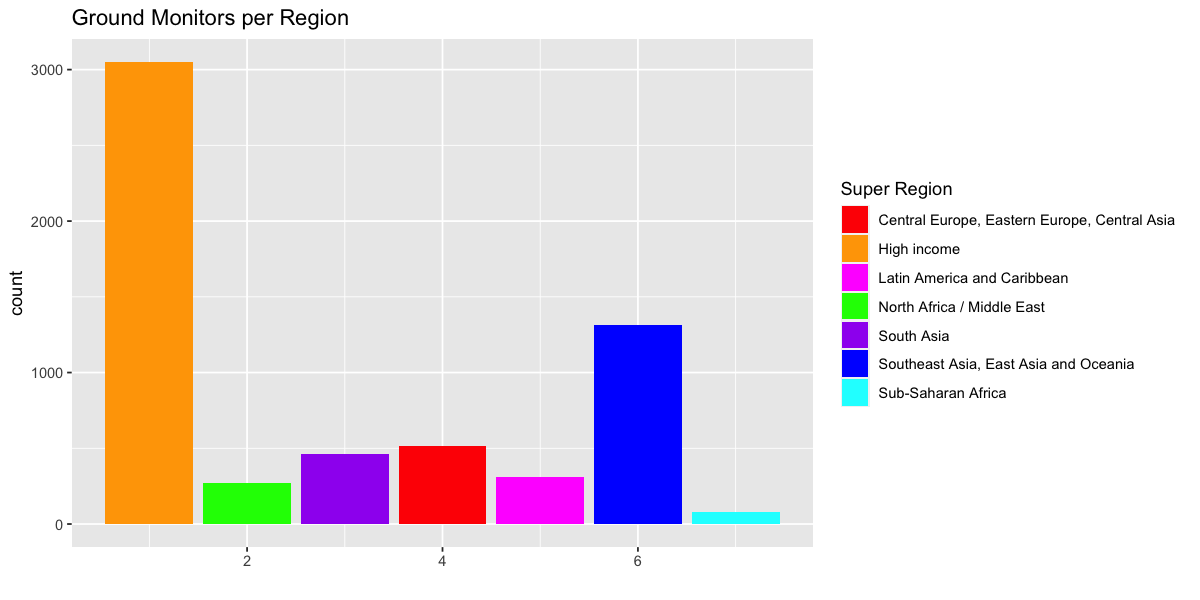

In [7]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot() +
    geom_bar(data=sites, aes(x=super_region, fill=factor(super_region_name))) +
    scale_fill_manual(values = c('red', 'orange', 'magenta', 'green', 'purple', 'blue', 'cyan')) +
    ggtitle('Ground Monitors per Region') + xlab('') + labs(fill='Super Region')

### Ground monitors per country

The number of per-country ground monitors depends on the size, overall development, and population density of the country.  China, the US, and India dominate, followed by other high income regions.

In [8]:
sites %>%
  group_by(iso3) %>%
  summarise(count = n()) %>%
  arrange(desc(count)) %>%
  head(5)

iso3 count geometry                      
1 CHN  1200  MULTIPOINT ((100.7717 22.00...
2 USA   727  MULTIPOINT ((-68.2609 44.37...
3 IND   436  MULTIPOINT ((95.67275 27.28...
4 FRA   408  MULTIPOINT ((-1.48916 43.47...
5 ITA   340  MULTIPOINT ((7.538055 44.38...

In [9]:
counts = sites %>%
  select(iso3) %>%
  count(iso3)

print(summary(counts$n))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     4.0     9.0    56.1    38.0  1200.0 


Of these 107 countries surveyed, the median number of monitors per country is 9. We can visualize this distribution as a bar plot. Is this useful?

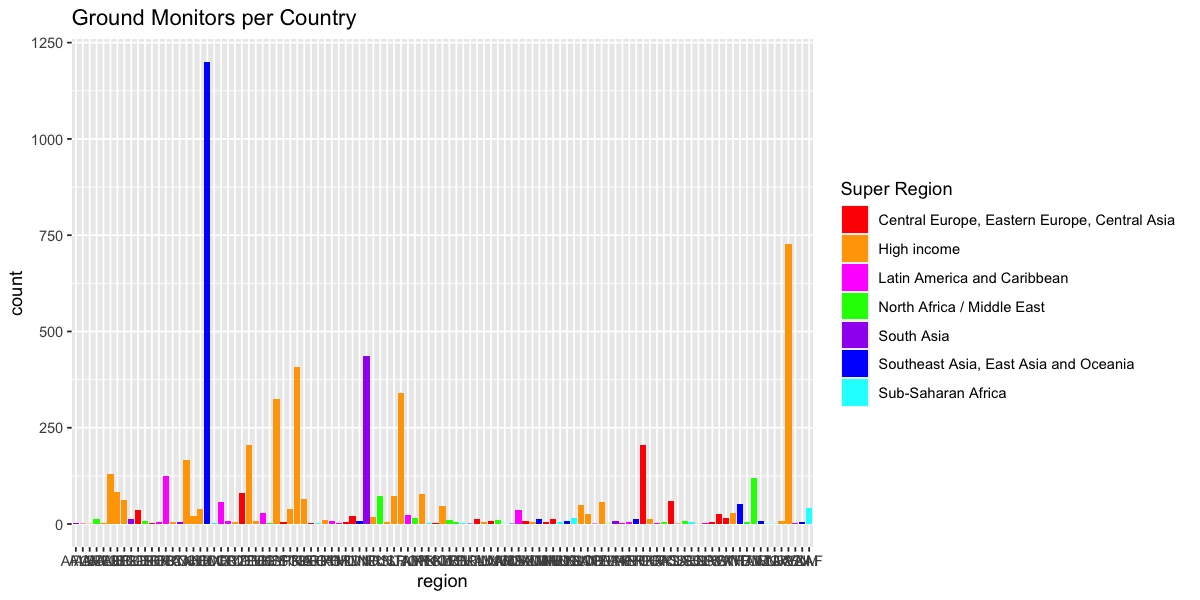

In [10]:
ggplot() +
    geom_bar(data=sites, aes(x=iso3, fill=factor(super_region_name))) +
    scale_fill_manual(values = c('red', 'orange', 'magenta', 'green', 'purple', 'blue', 'cyan')) +
    ggtitle('Ground Monitors per Country') + xlab('region') + labs(fill='Super Region')

## Which features to use in the model?

Gabry et al consider 3 alternatives:

* Complete pooling - regress ground monitor readings on satellite data; all sites are the same.
* Partial pooling by WHO super region
* Partial pooling based on hierachical clustering of country-level average of ground monitor readings
   + here we also consider clustering on average of *log* ground monitor reading


### Cluster by ground monitor ${PM}_{2.5}$

What are the groupings for hierarhical clustering by ground monitor ${PM}_{2.5}$?

In [11]:
cat("Sites per cluster_region")
table(sites$cluster_region)

Sites per cluster_region


   1    2    3    4    5    6 
  27 3534 1696  418  315   13 

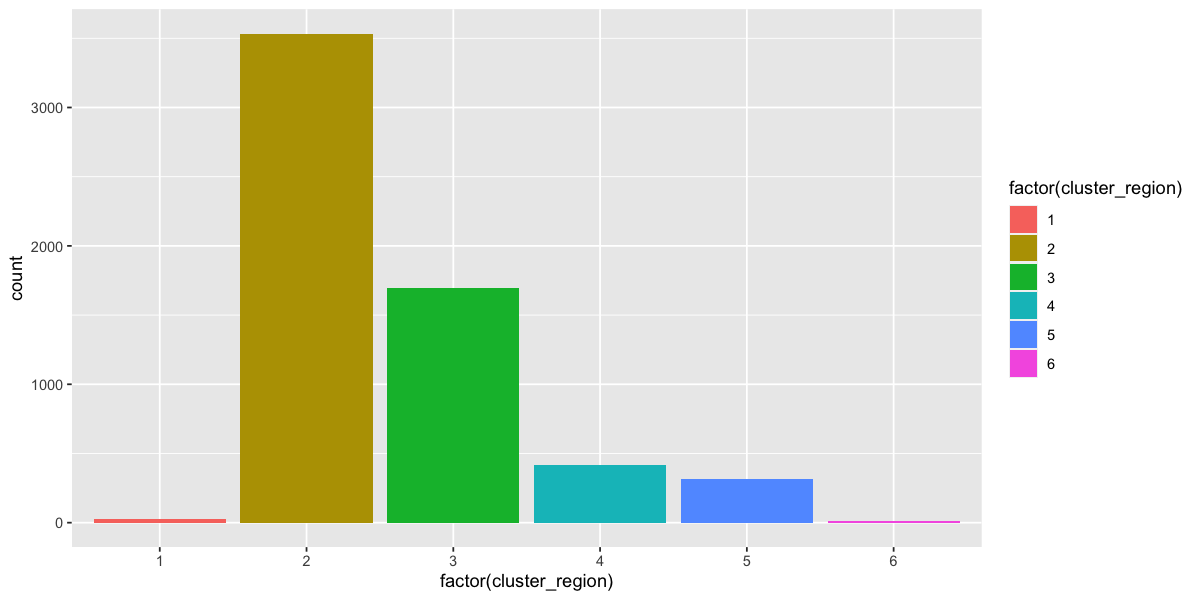

In [12]:
ggplot() +
    geom_bar(data=sites, aes(x=factor(cluster_region), fill=factor(cluster_region)))

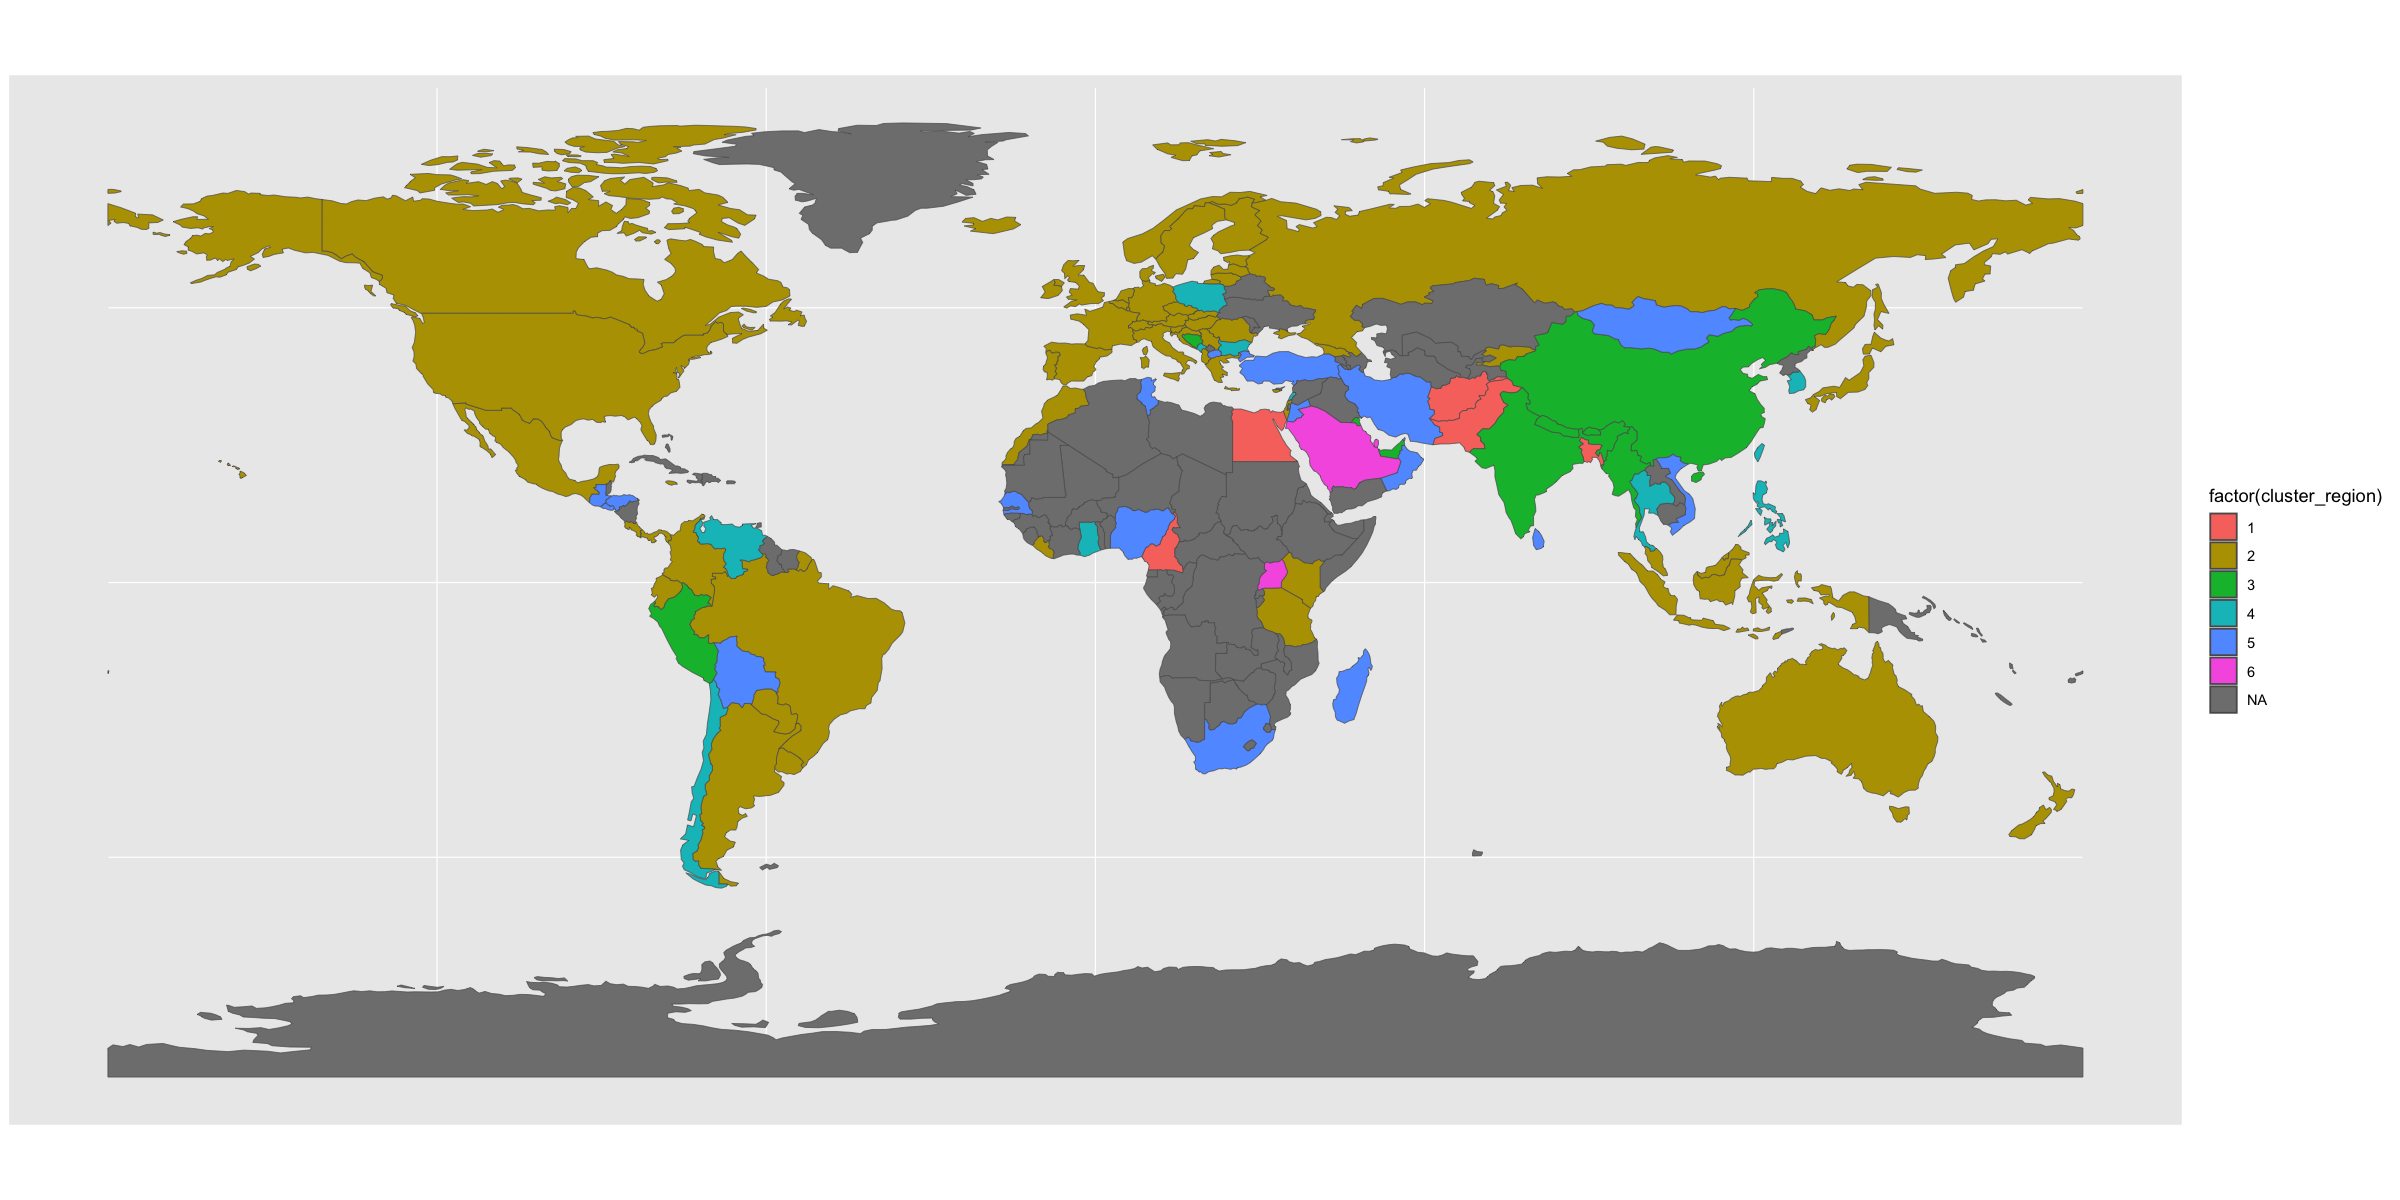

In [13]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot() +  
 geom_sf(data = world_map_plus_gdf, aes(fill=factor(cluster_region)))

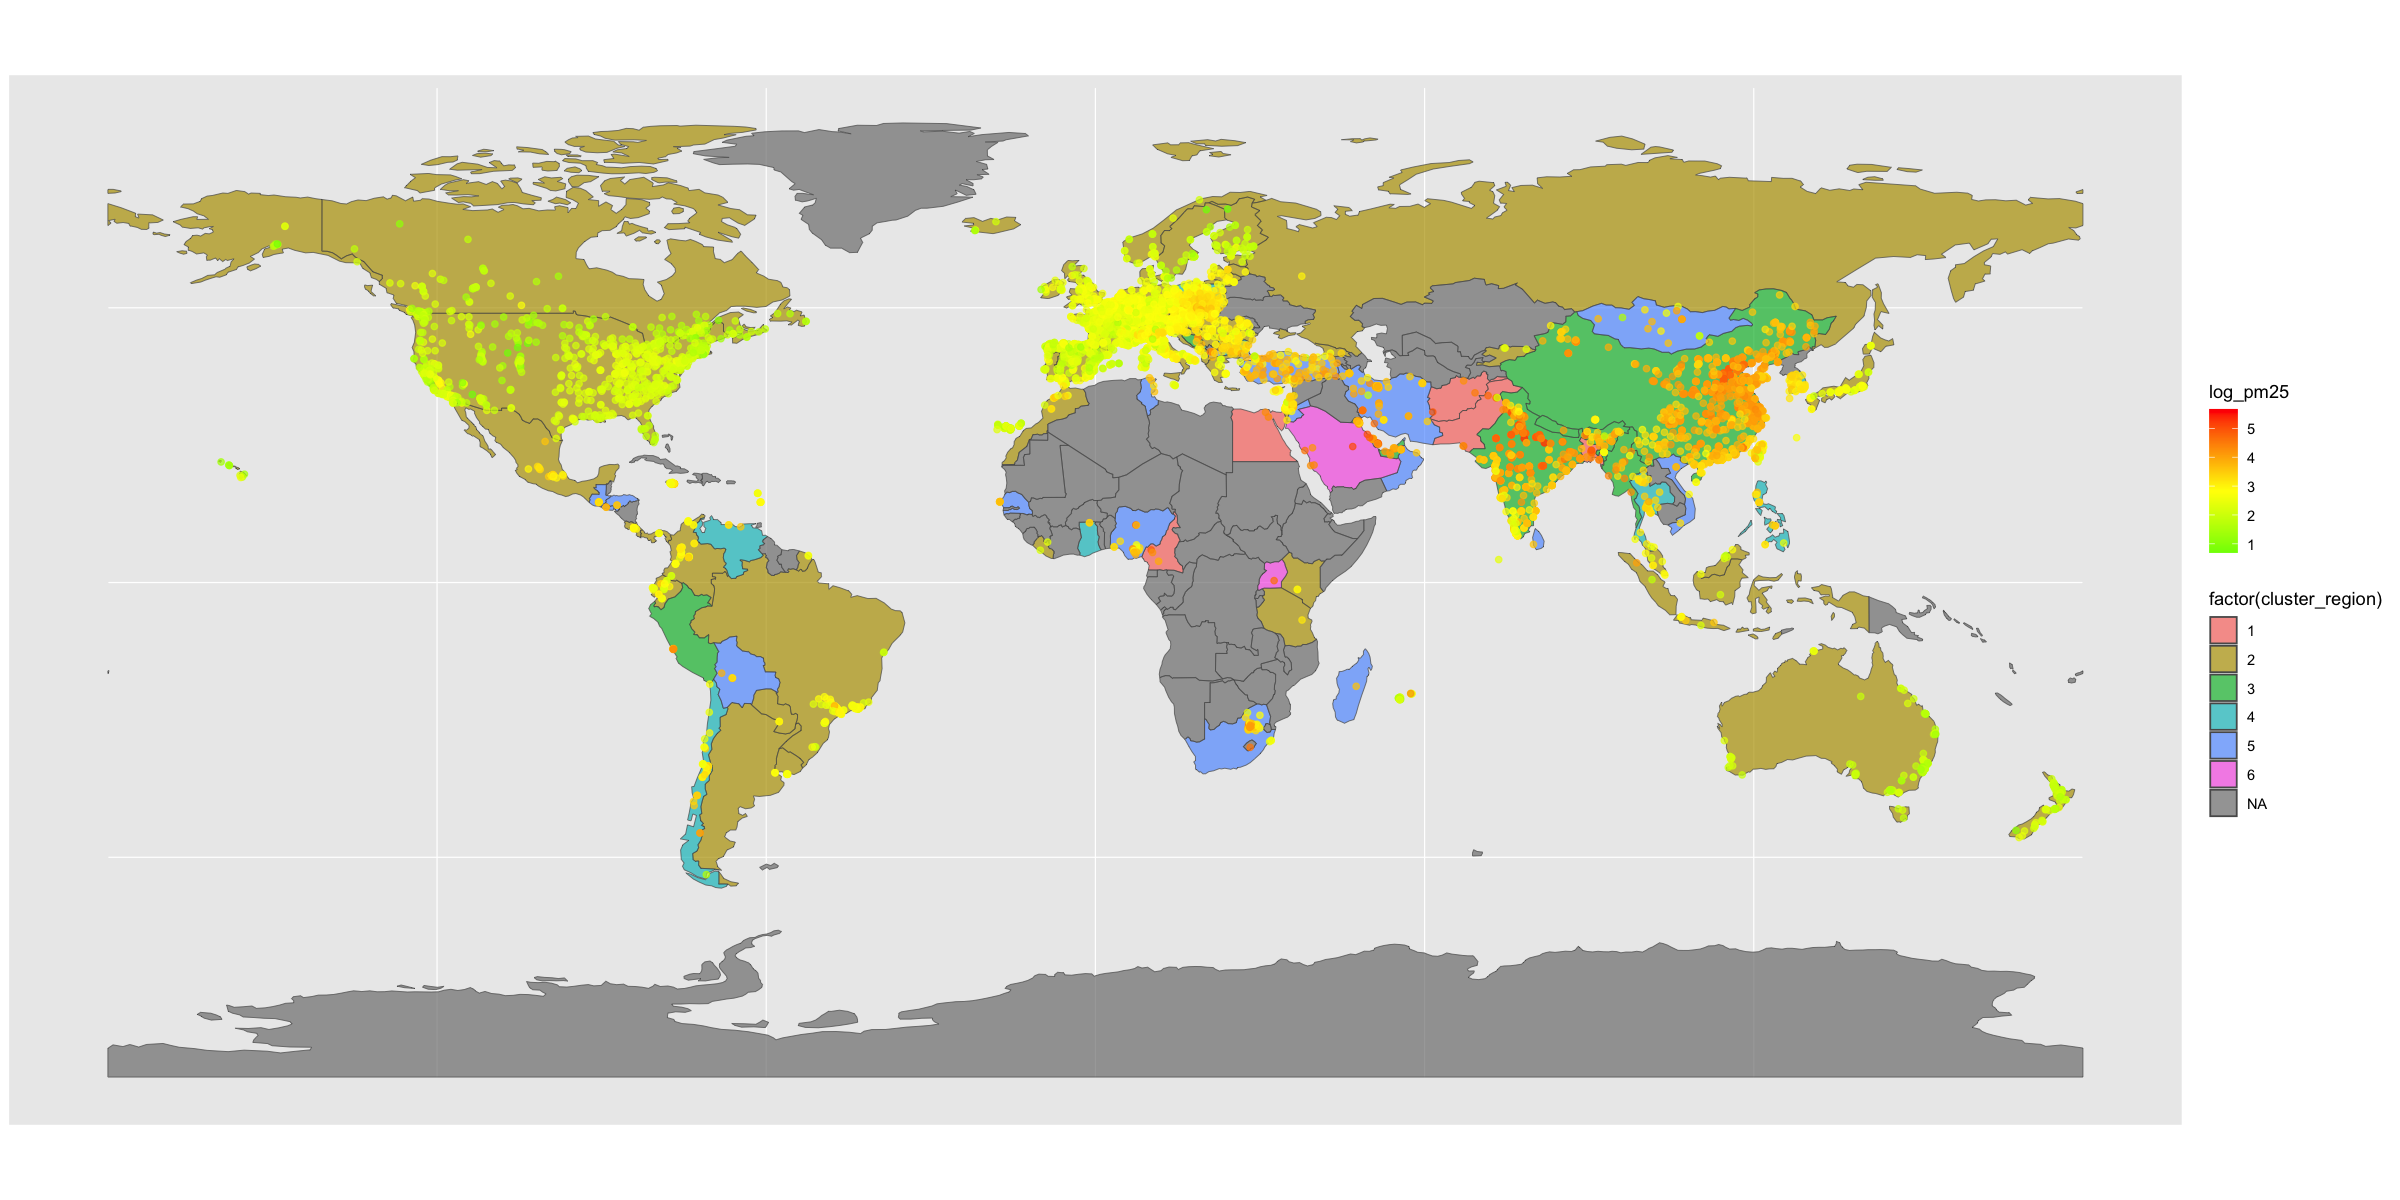

In [14]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot() +  
 geom_sf(data = world_map_plus_gdf, aes(fill=factor(cluster_region)), alpha=0.7) +
 geom_sf(data = sites, aes(color=log_pm25), alpha=0.7) +
 scale_color_gradient2(low='green', mid='yellow', high='red', midpoint=2.8)

### Cluster by log of ground monitor ${PM}_{2.5}$

In [15]:
cat("Sites per cluster_log_region")
table(sites$cluster_log_region)

Sites per cluster_log_region


   1    2    3    4    5    6 
  42 1677 1555 1694  347  688 

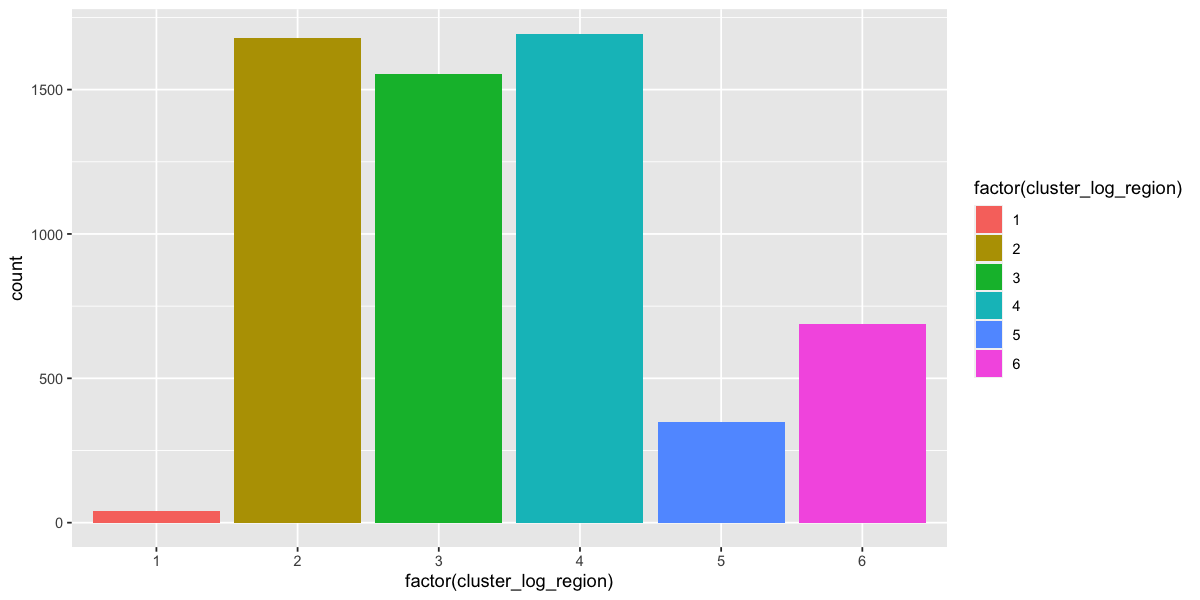

In [16]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot() +
    geom_bar(data=sites, aes(x=factor(cluster_log_region), fill=factor(cluster_log_region)))

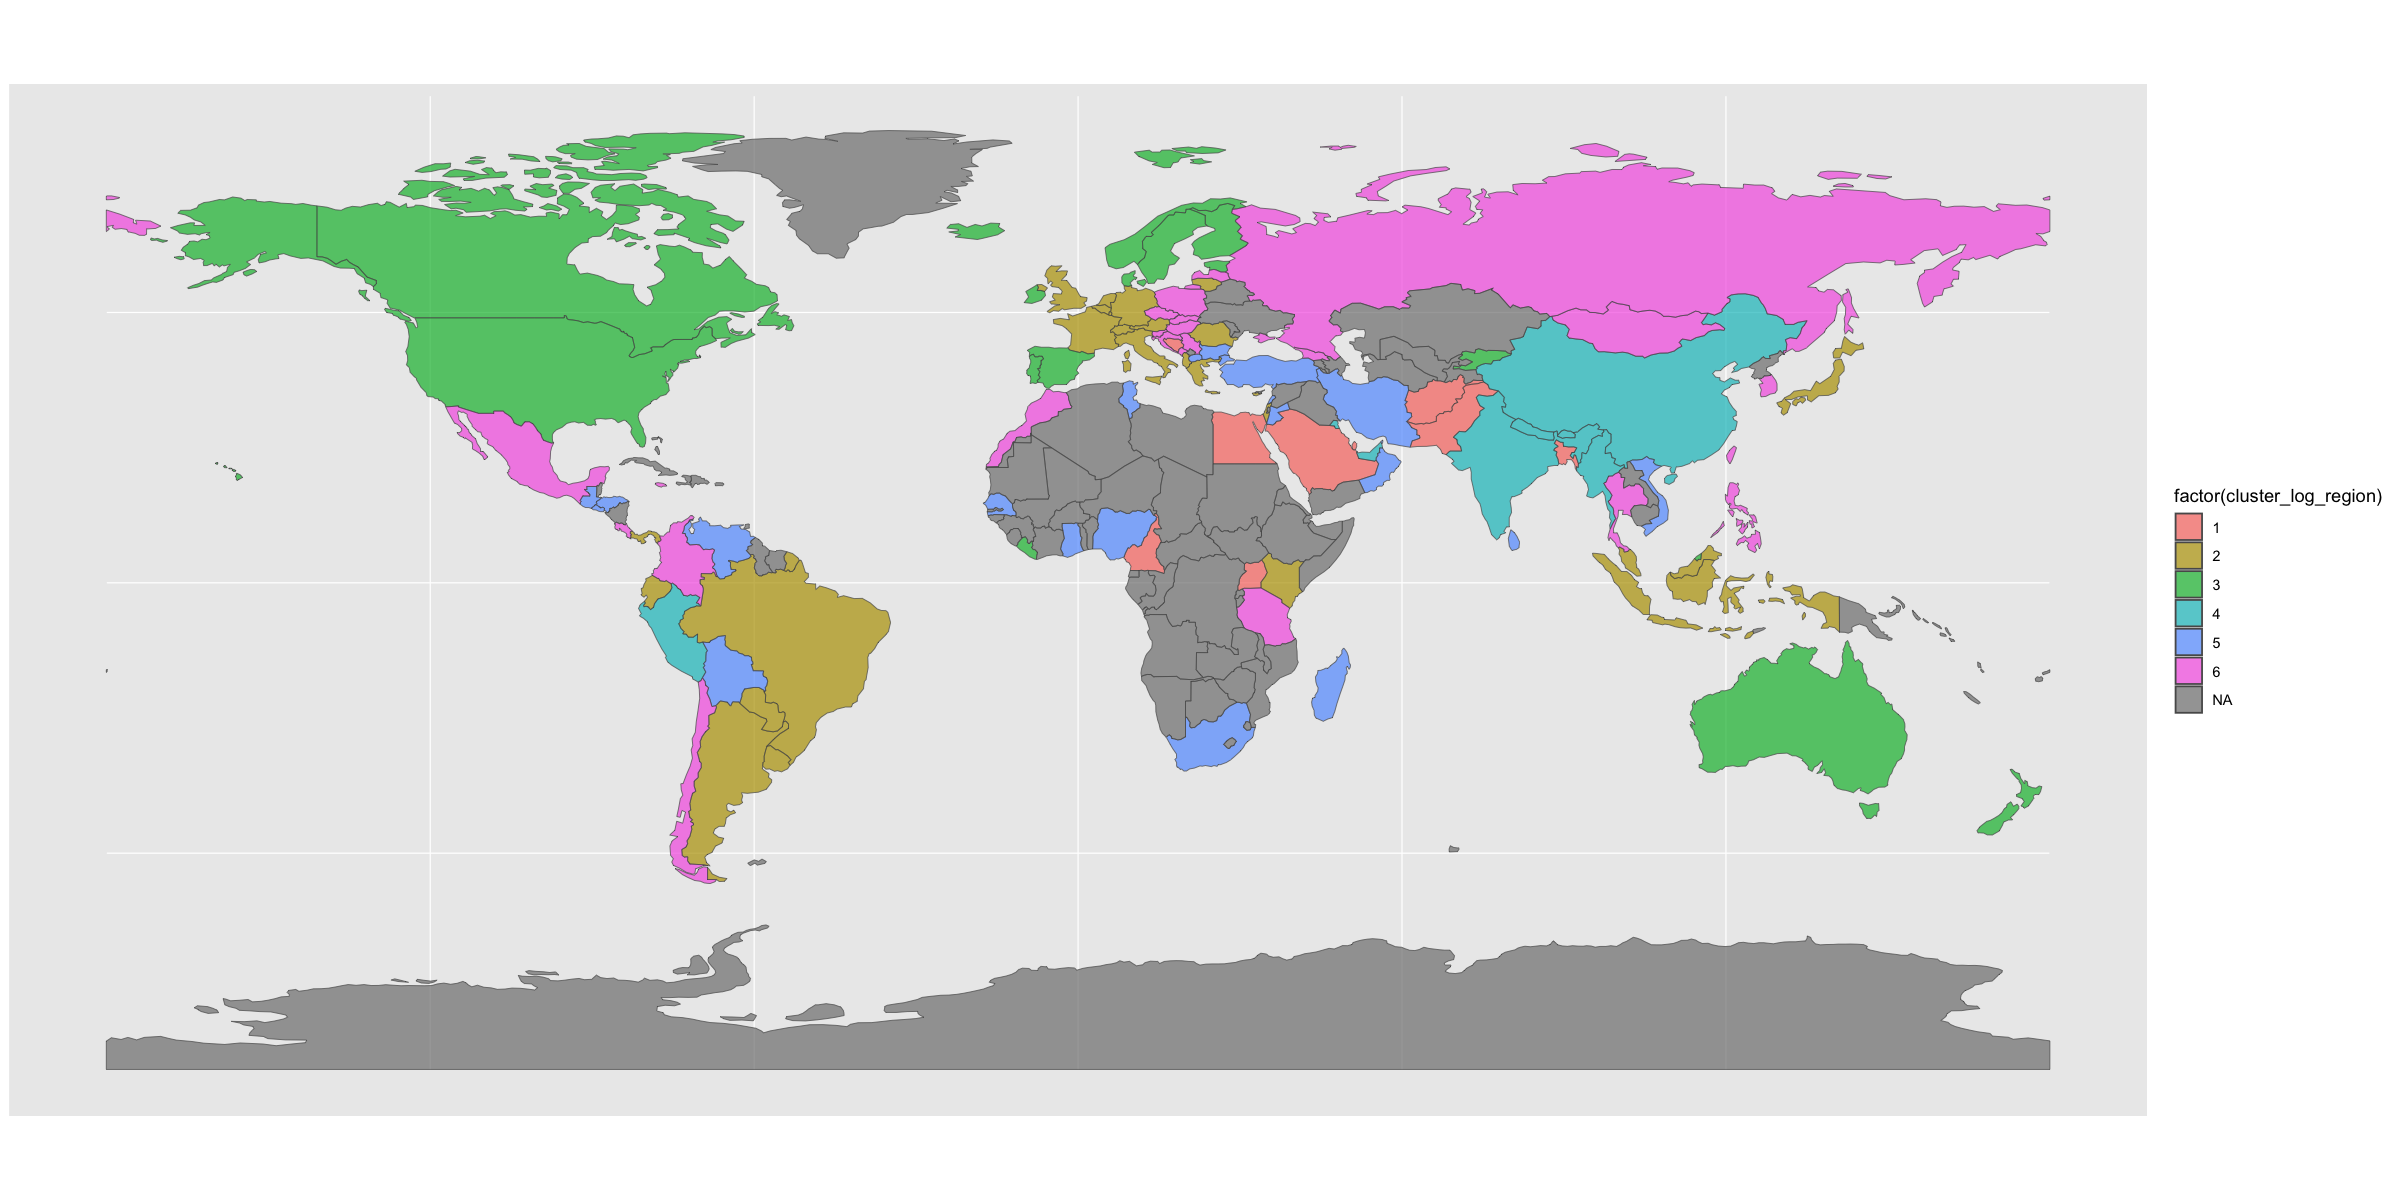

In [17]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot() +  
 geom_sf(data = world_map_plus_gdf, aes(fill=factor(cluster_log_region)), alpha=0.7)

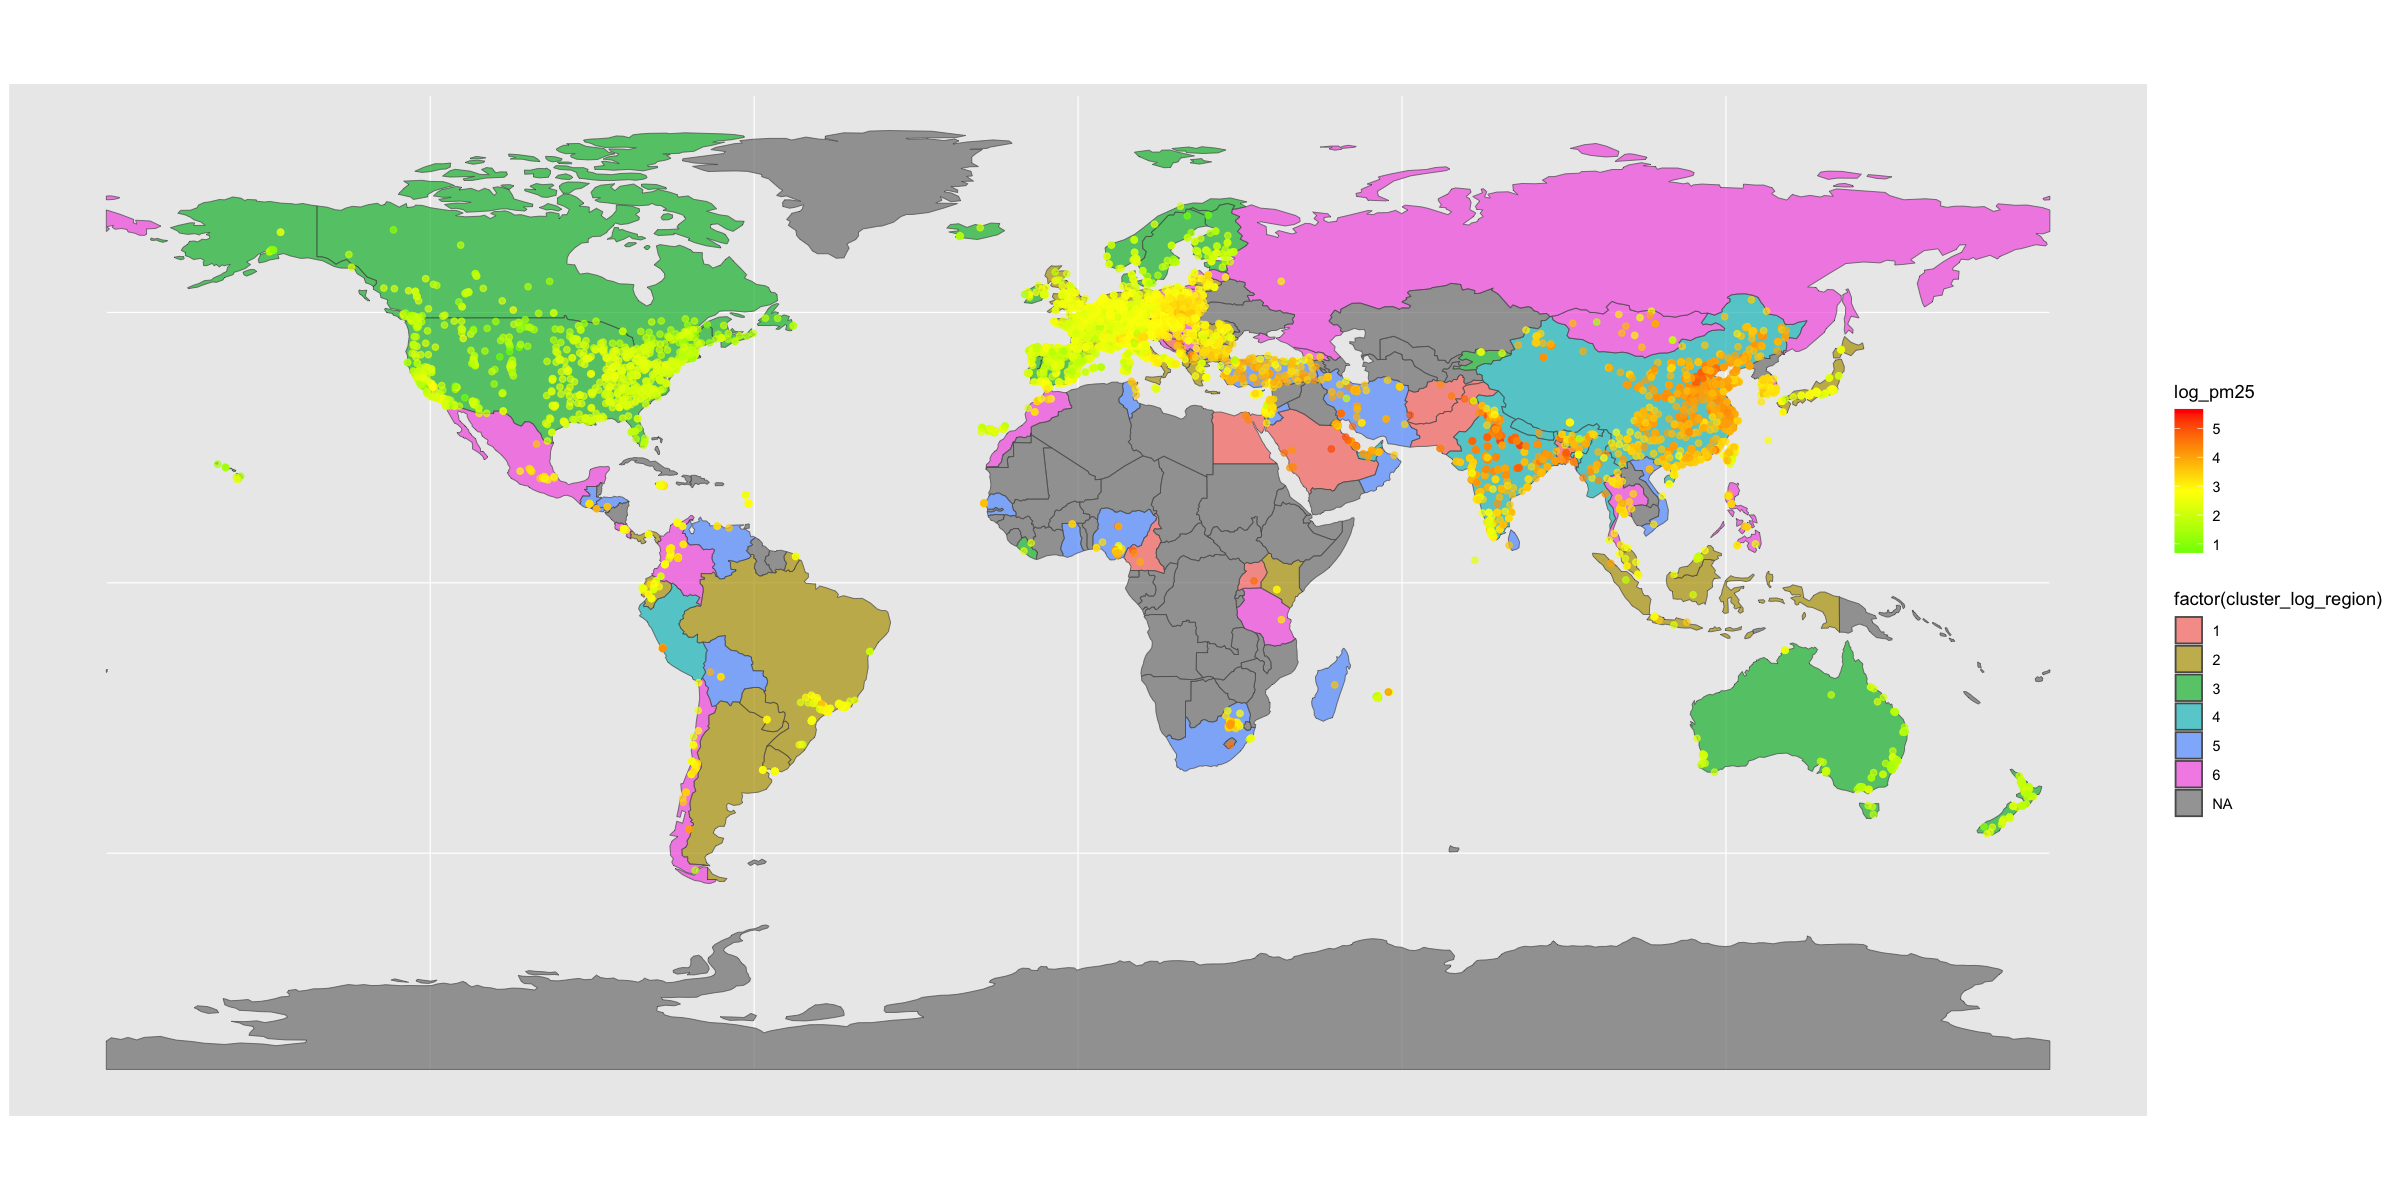

In [18]:
ggplot() +  
 geom_sf(data = world_map_plus_gdf, aes(fill=factor(cluster_log_region)), alpha=0.7) +
 geom_sf(data = sites, aes(color=log_pm25), alpha=0.7) +
 scale_color_gradient2(low='green', mid='yellow', high='red', midpoint=2.8)